In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [40]:
df.head(5)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,SepsisLabel
0,88.0,96.0,36.915884,101.0,82.0,73.0,24.000000,30.000000,0.0
1,83.0,93.0,36.915884,116.0,90.0,76.0,27.000000,32.983815,0.0
2,100.0,100.0,35.500000,136.5,90.5,68.0,12.000000,32.983815,0.0
3,72.0,96.0,36.915884,100.0,80.0,68.0,18.700589,32.983815,0.0
4,112.0,100.0,36.915884,121.0,76.0,58.0,21.000000,32.983815,0.0


In [41]:
labels = df['SepsisLabel'].values

In [42]:
labels

array([0., 0., 0., ..., 0., 1., 1.])

In [43]:
features_df = df.loc[:, 'HR':'EtCO2']

In [44]:
features_df.head(5)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2
0,88.0,96.0,36.915884,101.0,82.0,73.0,24.000000,30.000000
1,83.0,93.0,36.915884,116.0,90.0,76.0,27.000000,32.983815
2,100.0,100.0,35.500000,136.5,90.5,68.0,12.000000,32.983815
3,72.0,96.0,36.915884,100.0,80.0,68.0,18.700589,32.983815
4,112.0,100.0,36.915884,121.0,76.0,58.0,21.000000,32.983815


#### Converting features to array (Important step for neural networks)

In [45]:
features = features_df.values

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=6250)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=6250)

In [47]:
print(X_train)
print('\n-----------------------------------\n')
print(X_train.shape)

[[ 64.          97.08456568  36.9158836  ...  53.          18.70058855
   32.98381545]
 [ 80.          96.          36.9158836  ...  74.          20.
   32.98381545]
 [ 55.         100.          37.4        ...  41.          14.
   32.98381545]
 ...
 [ 65.         100.          36.9158836  ...  52.          17.
   32.98381545]
 [ 80.         100.          35.85       ...  74.          12.
   32.98381545]
 [ 90.         100.          36.9158836  ...  63.          10.
   32.98381545]]

-----------------------------------

(105672, 8)


In [48]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# lets fix the random seeds for reproducibility.
torch.manual_seed(6250)
if torch.cuda.is_available():
    torch.cuda.manual_seed(6250)

In [49]:
trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(2), torch.from_numpy(y_train.astype('long')))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

testset = TensorDataset(torch.from_numpy(X_test.astype('float32')).unsqueeze(2), torch.from_numpy(y_test.astype('long')))
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)
classes = ('NO Sepsis', 'Sepsis')

In [50]:
validset = TensorDataset(torch.from_numpy(X_valid.astype('float32')).unsqueeze(2), torch.from_numpy(y_valid.astype('long')))
validloader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False, num_workers=2)

#### RNN

In [51]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=8, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(in_features=8, out_features=2)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


model = RecurNet()

In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [53]:
cuda = torch.cuda.is_available()
if cuda:
    model = model.cuda()

train_losses = []
valid_losses = []

for epoch in range(15):  # loop over the dataset multiple times
#     print('1')
    # set the model as train mode
    model.train()
    train_loss = 0.0
    train_counter = 0
#     print('2')
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, targets = data
#         targets = torch.tensor(targets, dtype=torch.long)

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
#         print('4')

        # forward + backward + optimize
        outputs = model(inputs)
#         print('5')
        loss = criterion(outputs, torch.tensor(targets, dtype=torch.long))
#         print('6')
        loss.backward()
        optimizer.step()
#         print('7')
        
        train_loss += (loss.item() * inputs.size(0))
        train_counter += inputs.size(0)

    train_losses.append(train_loss/train_counter)
    
    # switch to evaluation mode
    model.eval()
    valid_loss = 0.0
    valid_counter = 0
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # get the inputs
            inputs, targets = data

            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, torch.tensor(targets, dtype=torch.long))

            valid_loss += (loss.item() * inputs.size(0))
            valid_counter += inputs.size(0)
    valid_losses.append(valid_loss/valid_counter)
    
print('Finished Training')

C:\Users\hmeht\Anaconda3\envs\hw5\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\hmeht\Anaconda3\envs\hw5\lib\site-packages\ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Finished Training


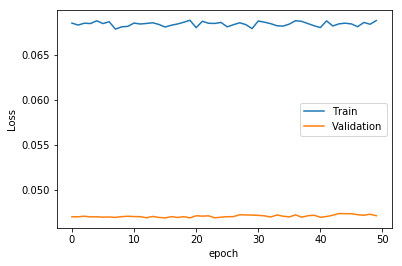

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc="best")

In [36]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        # get the inputs
        inputs, targets = data

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) 
        predicted = predicted.long()
        targets = targets.long()
        c = (predicted == targets).squeeze()
#         print(c.dim())
        for i, label in enumerate(targets):
            if c.dim() == 0:
                class_correct[label] += c.item()
                class_total[label] += 1
            else:
                class_correct[label] += c[i].item()
                class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %s : %2d%% out of %d cases' % (classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))

Accuracy of NO Sepsis : 100% out of 157 cases
Accuracy of Sepsis :  0% out of 1 cases
